Training the CNN using a fast PyTorch Approach

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from matplotlib import pyplot as plt
from PIL import Image
from torch.utils.data import ConcatDataset

In [3]:
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# Transforms
transformer = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],
                         [0.5,0.5,0.5])
    ])

In [5]:
train_path = '/content/drive/MyDrive/Satelite Image Classification/data/train'
test_path = '/content/drive/MyDrive/Satelite Image Classification/data/test'
batch_size = 128
# # DataLoader
# train_loader = DataLoader(
#     torchvision.datasets.ImageFolder(train_path, transform=transformer),
#     batch_size=batch_size, shuffle=True
# )
# test_loader = DataLoader(
#     torchvision.datasets.ImageFolder(test_path, transform=transformer),
#     batch_size=batch_size, shuffle=True
# )

# Transforms with data augmentation
def add_noise(img, factor=0.01):
    noise = torch.randn_like(img) * factor  # Modifica la deviazione standard a seconda di quanto rumore desideri aggiungere
    noisy_img = img + noise
    return noisy_img
transform_with_augmentation = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_noise(x, factor=0.0075)),  # Aggiungi rumore usando la funzione add_noise
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# # Transforms for test set (without data augmentation)
transform_without_augmentation = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# # DataLoader with and without data augmentation for training set
# train_loader_augmented = DataLoader(
#     torchvision.datasets.ImageFolder(train_path, transform=transform_without_augmentation),
#     batch_size=batch_size, shuffle=True
# )
# train_loader = DataLoader(
#     torchvision.datasets.ImageFolder(train_path, transform=transform_with_augmentation),
#     batch_size=batch_size, shuffle=True
# )

# Creazione dei dataset
original_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform_with_augmentation)
augmented_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform_without_augmentation)

# Creazione del ConcatDataset
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Creazione del DataLoader utilizzando il ConcatDataset
train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# DataLoader without data augmentation for test set
test_loader = DataLoader(
    torchvision.datasets.ImageFolder(test_path, transform=transform_without_augmentation),
    batch_size=batch_size, shuffle=True
)

In [14]:
for (a,b) in train_loader:
  print(a.shape, b.shape)

torch.Size([128, 3, 150, 150]) torch.Size([128])


KeyboardInterrupt: ignored

In [7]:
# categories / classes
root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(f'{len(classes)} classes found:')
classes

19 classes found:


['agricultural',
 'airplane',
 'baseballdiamond',
 'beach',
 'buildings',
 'chaparral',
 'forest',
 'freeway',
 'golfcourse',
 'harbor',
 'intersection',
 'mobilehomepark',
 'overpass',
 'parkinglot',
 'residential',
 'river',
 'runway',
 'storagetanks',
 'tenniscourt']

CNN Model with PyTorch

In [8]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=21):
    super(ConvNet, self).__init__()
    drop = 0.02

    # Reminder: output size -> ((w-f+2P)/s) + 1
    # Input shape defined by -> [batch_size, RGB, img_shape[0], img_shape[1]]
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1) # shape = [256, 12, 150, 150]
    self.drop1 = torch.nn.Dropout(drop)
    self.bn1 = nn.BatchNorm2d(num_features=12)  # shape = [256, 12, 150, 150]
    self.relu1 = nn.ReLU()  # shape = [256, 12, 150, 150]

    self.pool = nn.MaxPool2d(kernel_size=2)  # shape = [256, 12, 75, 75]

    self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1) # shape = [256, 20, 75, 75]
    self.drop2 = torch.nn.Dropout(drop)
    self.relu2 = nn.ReLU()  # shape = [256, 20, 75, 75]

    # self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1) # shape = [256, 32, 75, 75]
    # self.drop3 = torch.nn.Dropout(drop)
    # self.bn3 = nn.BatchNorm2d(num_features=32)  # shape = [256, 32, 75, 75]
    # self.relu3 = nn.ReLU()  # shape = [256, 32, 75, 75]

    self.lin1 = nn.Linear(in_features=20*75*75, out_features=256)
    self.lin2 = nn.Linear(in_features=256, out_features=num_classes)
    # self.lin3 = nn.Linear(in_features=128, out_features=num_classes)


  # feed forward function
  def forward(self, input):
    output = self.conv1(input)
    output = self.drop1(output)
    output = self.bn1(output)
    output = self.relu1(output)

    output = self.pool(output)

    output = self.conv2(output)
    output = self.drop2(output)
    output = self.relu2(output)

    # output = self.conv3(output)
    # output = self.drop3(output)
    # output = self.bn3(output)
    # output = self.relu1(output) # shape = [256, 32, 75, 75]

    output = output.view(-1, 20*75*75)
    output = self.lin1(output)
    output = self.lin2(output)
    # output = self.lin3(output)

    return output



In [9]:
model = ConvNet(num_classes=21).to(device)

In [10]:
# set Optimizer and Loss Function
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

In [11]:
# size train test images
train_count = len(glob.glob(f'{train_path}/**/*.tif'))
test_count = len(glob.glob(f'{test_path}/**/*.tif'))
print(f'train size: {train_count}')
print(f'test size: {test_count}')

train size: 1515
test size: 585


In [12]:
num_epochs = 30

In [15]:
# Model Training

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_accuracy = 0.0

for epoch in range(num_epochs):
  print(f'--------- Epoch: {epoch + 1} ---------')
  # Model Training
  model.train()

  train_accuracy, train_loss = 0.0, 0.0
  for i, (images, labels) in enumerate(train_loader):

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.cpu().data*images.size(0)
    _, prediction = torch.max(outputs.data,1)

    train_accuracy += int(torch.sum(prediction==labels.data))

  train_accuracy = train_accuracy / (train_count * 2)   # !!! TOGLI IL x2 se modifichi il train_loader sdoppiato



  # Model Evaluation
  model.eval()

  test_accuracy, test_loss = 0.0, 0.0

  for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    # if torch.cuda.is_available():
    #   images = Variable(images.cuda())
    #   labels = Variable(labels.cuda())

    outputs = model(images)
    test_loss += loss_function(outputs, labels).cpu().data*images.size(0)
    _, prediction = torch.max(outputs.data,1)
    test_accuracy += int(torch.sum(prediction==labels.data))

  test_accuracy = test_accuracy / test_count


  # print info
  print(f'Train Loss: {train_loss}   -   Train Accuracy: {train_accuracy}')
  print(f'Test Loss: {test_loss}   -   Test Accuracy: {test_accuracy}')
  train_losses.append(train_loss), test_losses.append(test_loss)
  train_accs.append(train_accuracy), test_accs.append(test_accuracy)

  # save the best model
  if test_accuracy > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Satelite Image Classification/data/best_checkpoint_2.model')
    best_accuracy = test_accuracy





--------- Epoch: 1 ---------
Train Loss: 18004.298828125   -   Train Accuracy: 0.15544554455445544
Test Loss: 1750.342041015625   -   Test Accuracy: 0.08717948717948718
--------- Epoch: 2 ---------
Train Loss: 8988.064453125   -   Train Accuracy: 0.13663366336633664
Test Loss: 1695.688720703125   -   Test Accuracy: 0.1076923076923077
--------- Epoch: 3 ---------
Train Loss: 8316.2294921875   -   Train Accuracy: 0.18217821782178217
Test Loss: 1475.6361083984375   -   Test Accuracy: 0.22905982905982905
--------- Epoch: 4 ---------
Train Loss: 6608.9921875   -   Train Accuracy: 0.3940594059405941
Test Loss: 1356.677734375   -   Test Accuracy: 0.26837606837606837
--------- Epoch: 5 ---------
Train Loss: 5092.81640625   -   Train Accuracy: 0.5273927392739274
Test Loss: 1413.949951171875   -   Test Accuracy: 0.28717948717948716
--------- Epoch: 6 ---------
Train Loss: 4104.8876953125   -   Train Accuracy: 0.6293729372937293
Test Loss: 1432.70263671875   -   Test Accuracy: 0.30085470085470084

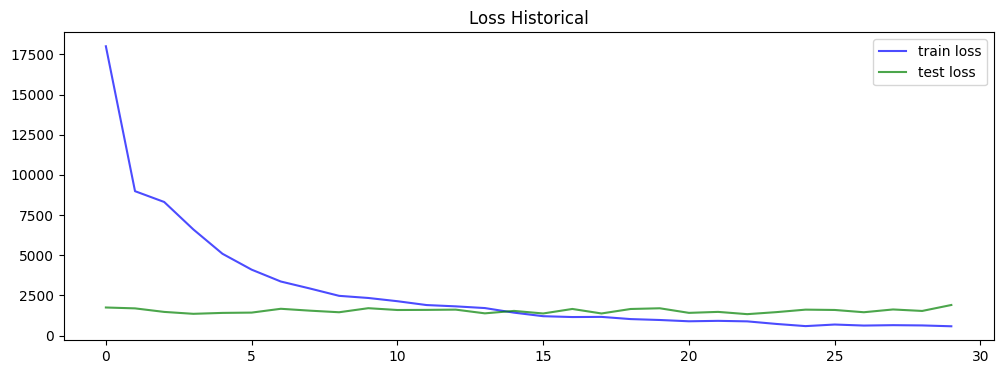

In [16]:
plt.figure(figsize=(12,4))
plt.plot(range(len(train_losses)), train_losses, c='blue', label='train loss', alpha=0.7)
plt.plot(range(len(test_losses)), test_losses, c='green', label='test loss', alpha=0.7)
plt.title(f'Loss Historical')
plt.legend()
plt.show()

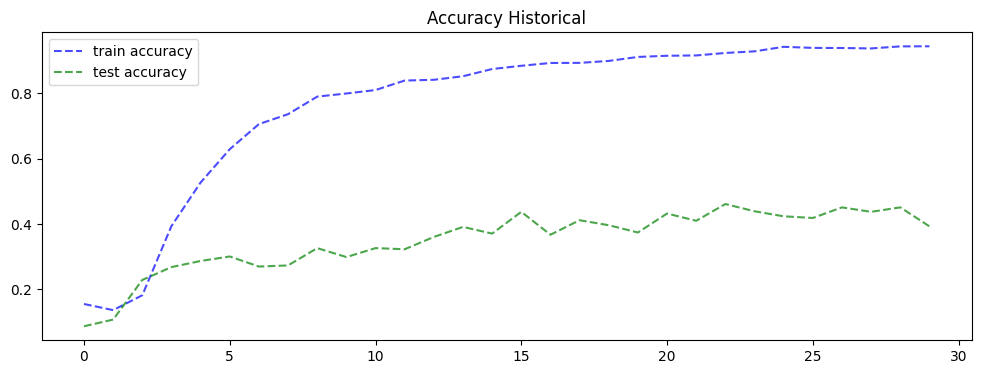

In [17]:
plt.figure(figsize=(12,4))
plt.plot(range(len(train_accs)), train_accs, c='blue', label='train accuracy', linestyle='dashed', alpha=0.7)
plt.plot(range(len(test_accs)), test_accs, c='green', label='test accuracy', linestyle='dashed', alpha=0.7)
plt.title(f'Accuracy Historical')
plt.legend()
plt.show()

In [18]:
print(best_accuracy)

0.46153846153846156


------------------------------------------------------------------------

Testing the Model

In [19]:
def prediction(img_path, transformer, visualize=False):

  print(img_path)

  image = Image.open(img_path)

  image_tensor = transformer(image).float()

  image_tensor = image_tensor.unsqueeze(0)

  image_tensor.to(device)

  output = model(image_tensor)

  index = output.data.numpy().argmax()

  pred = classes[index]

  if visualize:
    plt.figure(figsize=(5,5))
    image_pil = Image.open(img_path)
    image_np = plt.imread(img_path)
    plt.imshow(image_np)
    plt.title(f"prediction: {pred}")
    plt.show()

  return pred

In [20]:
# Load the trained Model
checkpoint = torch.load('/content/drive/MyDrive/Satelite Image Classification/data/best_checkpoint_2.model')
model = ConvNet(num_classes=21)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout(p=0.02, inplace=False)
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop2): Dropout(p=0.02, inplace=False)
  (relu2): ReLU()
  (lin1): Linear(in_features=112500, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=21, bias=True)
)

In [21]:
files = glob.glob('/content/drive/MyDrive/Satelite Image Classification/data/test/**/*.tif')

/content/drive/MyDrive/Satelite Image Classification/data/test/harbor/harbor45.tif


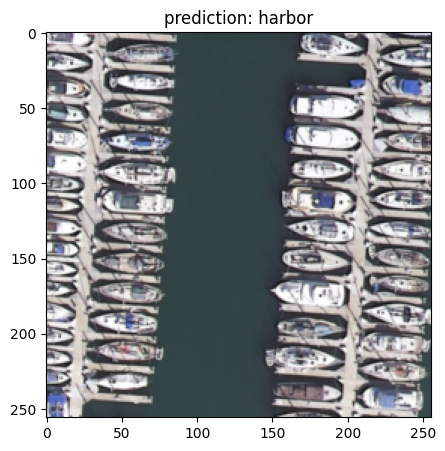

/content/drive/MyDrive/Satelite Image Classification/data/test/agricultural/agricultural44.tif


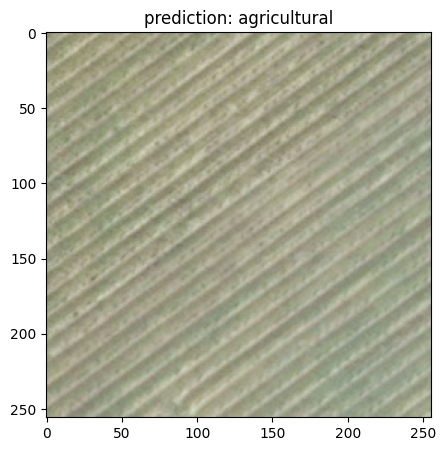

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/sparseresidential80.tif


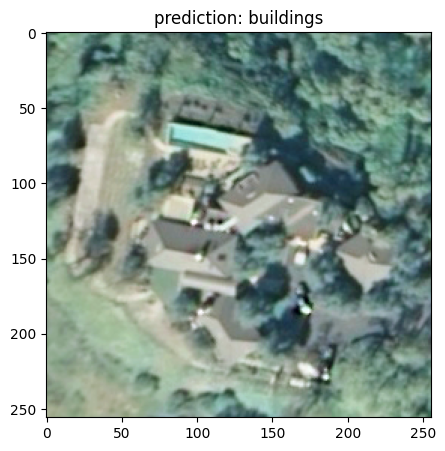

/content/drive/MyDrive/Satelite Image Classification/data/test/freeway/freeway82.tif


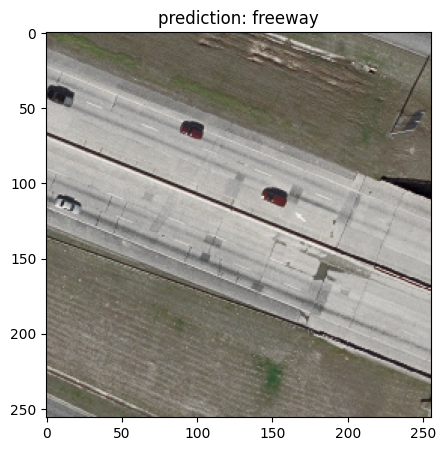

/content/drive/MyDrive/Satelite Image Classification/data/test/river/river81.tif


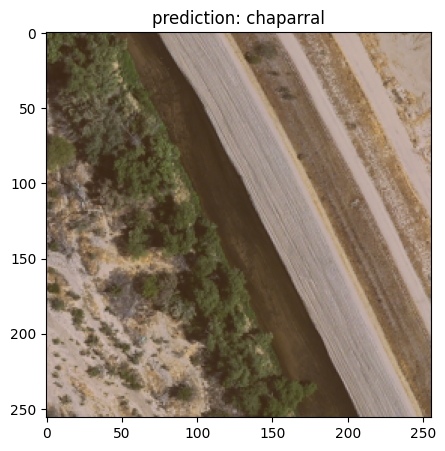

/content/drive/MyDrive/Satelite Image Classification/data/test/baseballdiamond/baseballdiamond18.tif


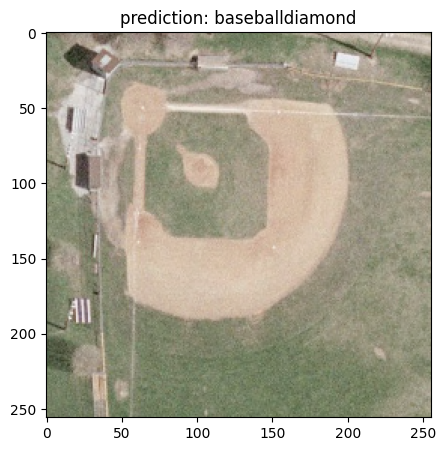

/content/drive/MyDrive/Satelite Image Classification/data/test/golfcourse/golfcourse31.tif


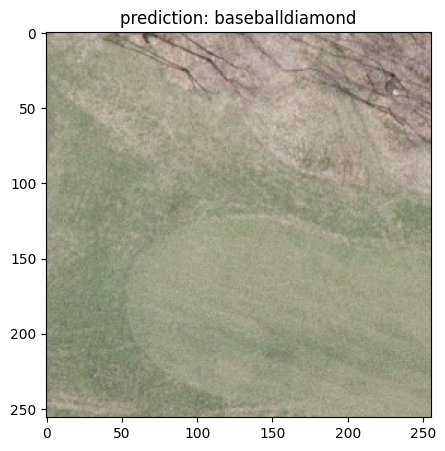

/content/drive/MyDrive/Satelite Image Classification/data/test/beach/beach83.tif


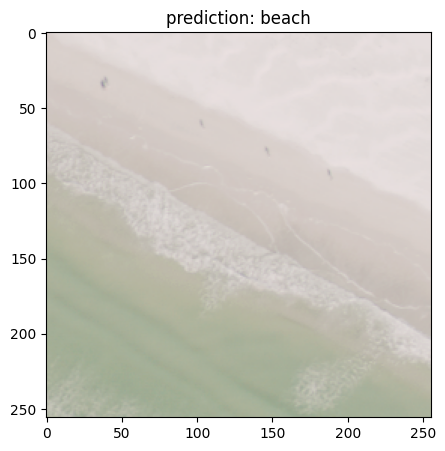

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/mediumresidential94.tif


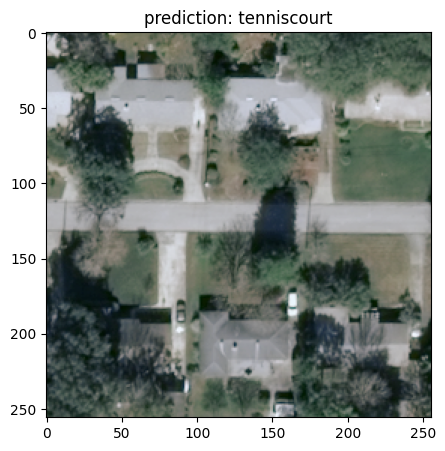

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/mediumresidential96.tif


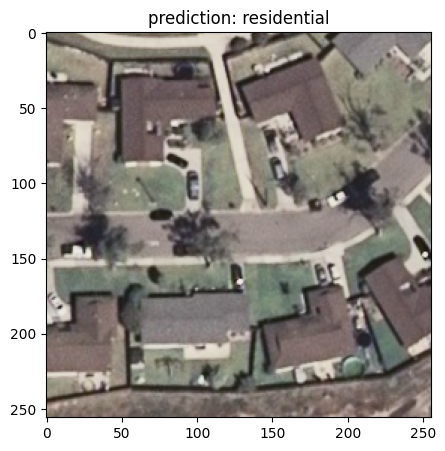

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/sparseresidential52.tif


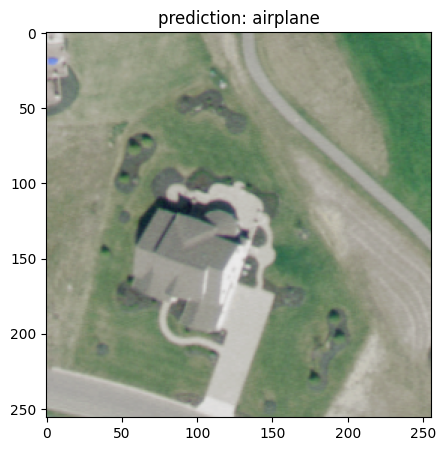

/content/drive/MyDrive/Satelite Image Classification/data/test/agricultural/agricultural79.tif


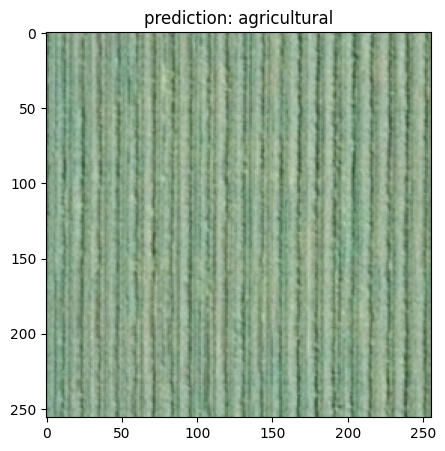

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/mediumresidential18.tif


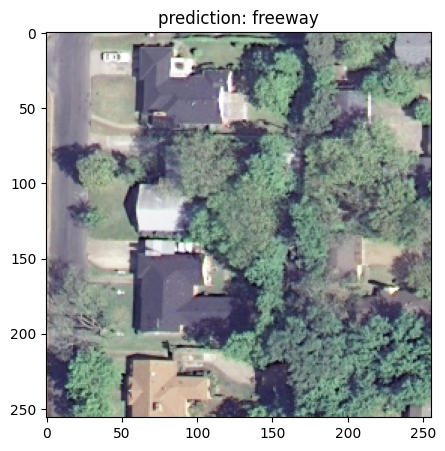

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/mediumresidential92.tif


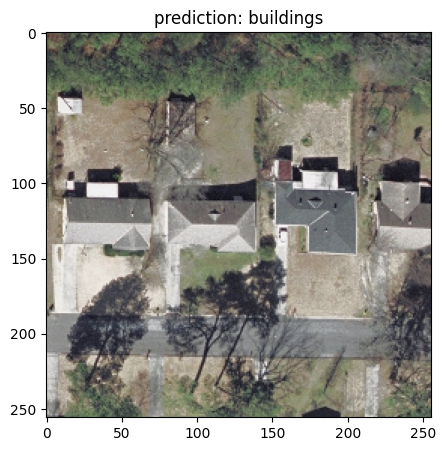

/content/drive/MyDrive/Satelite Image Classification/data/test/baseballdiamond/baseballdiamond74.tif


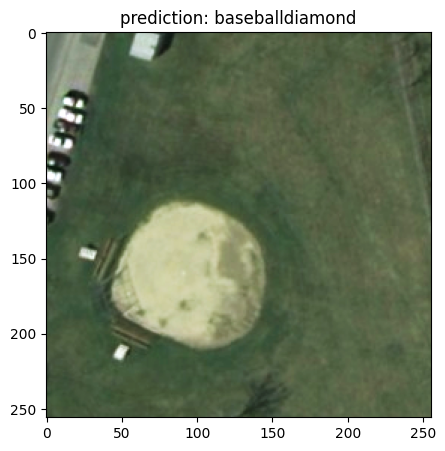

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/sparseresidential92.tif


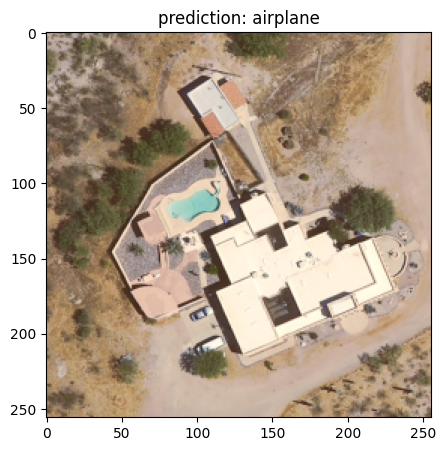

/content/drive/MyDrive/Satelite Image Classification/data/test/river/river50.tif


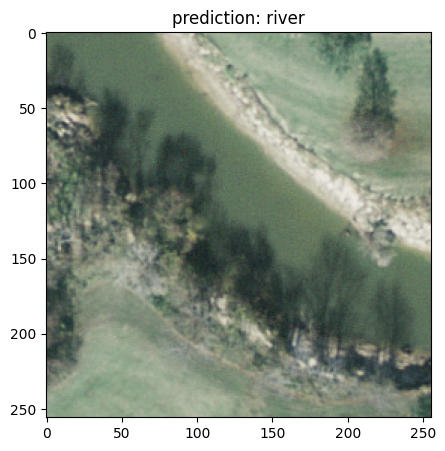

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/sparseresidential76.tif


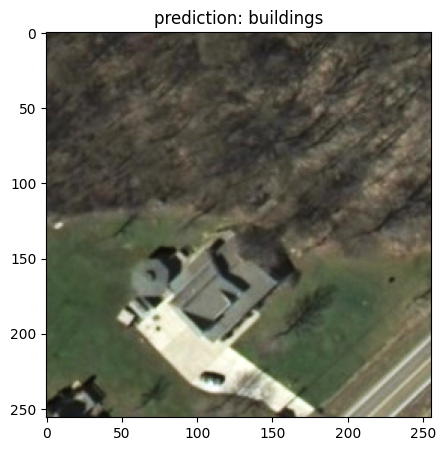

/content/drive/MyDrive/Satelite Image Classification/data/test/residential/sparseresidential58.tif


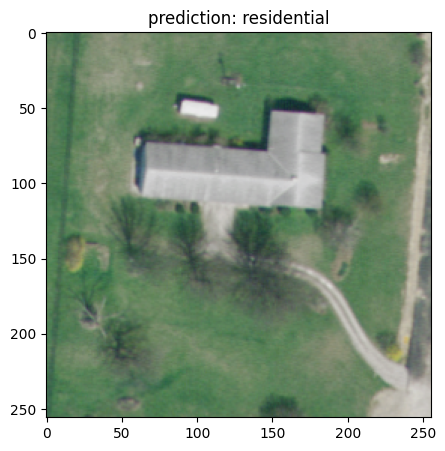

/content/drive/MyDrive/Satelite Image Classification/data/test/buildings/buildings40.tif


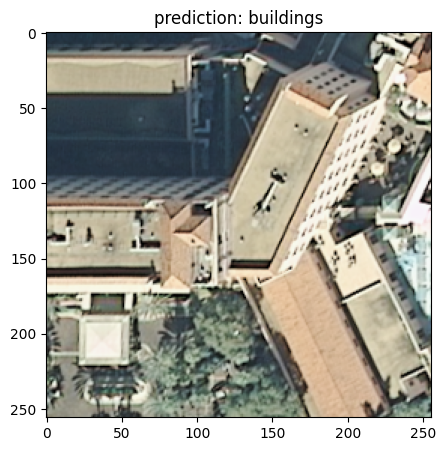

In [22]:
num = 20

for i in range(num):
  random_file_path = np.random.choice(files)
  prediction(random_file_path, transform_without_augmentation, visualize=True)

-----------------------------------

Confusion Matrix

In [23]:
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Carica il set di test
test_dataset = ImageFolder(root=test_path, transform=transform_without_augmentation)

# Crea il DataLoader per il set di test
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
class_names = test_dataset.classes

# Load the trained Model
checkpoint = torch.load('/content/drive/MyDrive/Satelite Image Classification/data/best_checkpoint_2.model')
model = ConvNet(num_classes=21)
model.load_state_dict(checkpoint)
model.eval()

# Inizializza le liste per le etichette vere e predette
true_labels = []
predicted_labels = []

Total Accuracy on Test Set: 46.15%


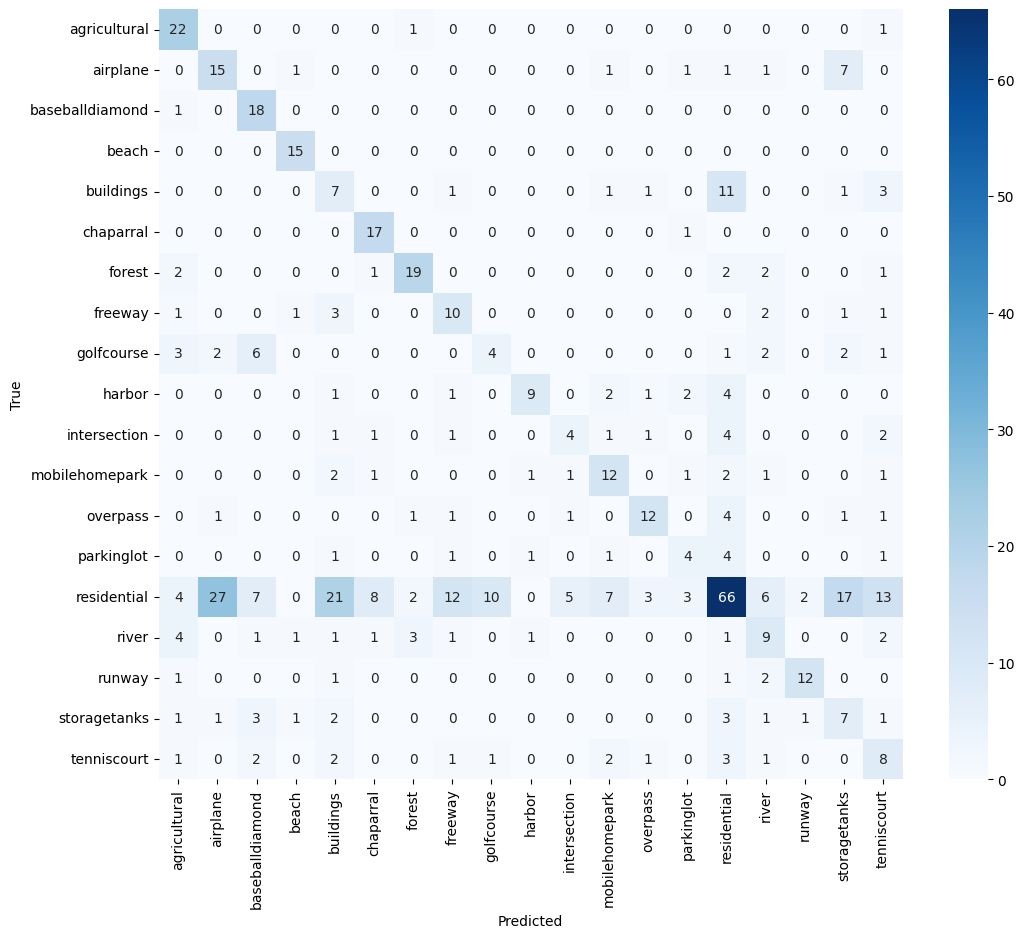

In [24]:
# Esegui la predizione sul set di test
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.append(labels.item())
        predicted_labels.append(predicted.item())

# total accuracy
total_accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Total Accuracy on Test Set: {total_accuracy * 100:.2f}%')

# Calcola e visualizza la matrice di confusione
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()